In [28]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from pydub import AudioSegment
import numpy as np

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [30]:
BLACKSTORK_FILE = os.path.join('data', 'blackstork', 'XC421077 - Black Stork - Ciconia nigra_segment10.wav')
NOT_BLACKSTORK_FILE = os.path.join('data', 'notbird', 'cicadas-noise-sound-effect-0.wav')

In [31]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

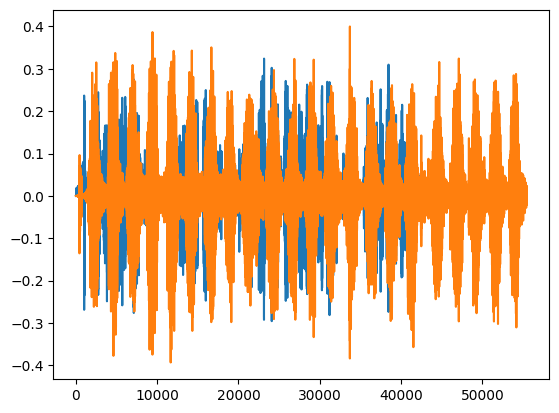

In [32]:
wave = load_wav_16k_mono(BLACKSTORK_FILE)
nwave = load_wav_16k_mono(NOT_BLACKSTORK_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

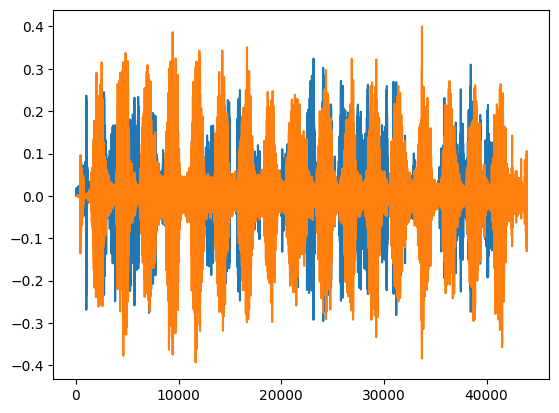

In [33]:
import numpy as np
import matplotlib.pyplot as plt
len_wave = len(wave)
len_nwave = len(nwave)
min_len = min(len_wave, len_nwave)
wave = wave[:min_len]
nwave = nwave[:min_len]
plt.plot(wave)
plt.plot(nwave)
plt.show()


In [34]:
POS = os.path.join('data', 'blackstork')
NEG = os.path.join('data', 'notbird')

In [35]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [36]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [37]:
import os
import wave
import time

def check_wav_format(filename):
    try:
        with wave.open(filename, 'rb') as wf:
            return wf.readframes(1) != b''
    except wave.Error:
        return False

def safe_remove_file(filepath):
    try:
        os.remove(filepath)
        print(f"Deleted {filepath}")
    except PermissionError:
        print(f"Could not delete {filepath} (file is in use).")

directory = 'data/blackstork'

# Get a list of files in the directory
file_list = os.listdir(directory)

# Iterate over the files and delete invalid WAV files
for filename in file_list:
    filepath = os.path.join(directory, filename)
    
    if not check_wav_format(filepath):
        safe_remove_file(filepath)

print("Deletion of invalid WAV files complete.")


Deletion of invalid WAV files complete.


In [38]:
lengths = []
for file in os.listdir(os.path.join('data', 'blackstork')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'blackstork', file))
    lengths.append(len(tensor_wave))

In [39]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=37780>

In [40]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [41]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [42]:
def preprocess(file_path, label): 
    print("File Path:", file_path)
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


In [43]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [44]:
spectrogram, label = preprocess(filepath, label)


File Path: b'data\\blackstork\\XC421074 - Black Stork - Ciconia nigra_segment144.wav'


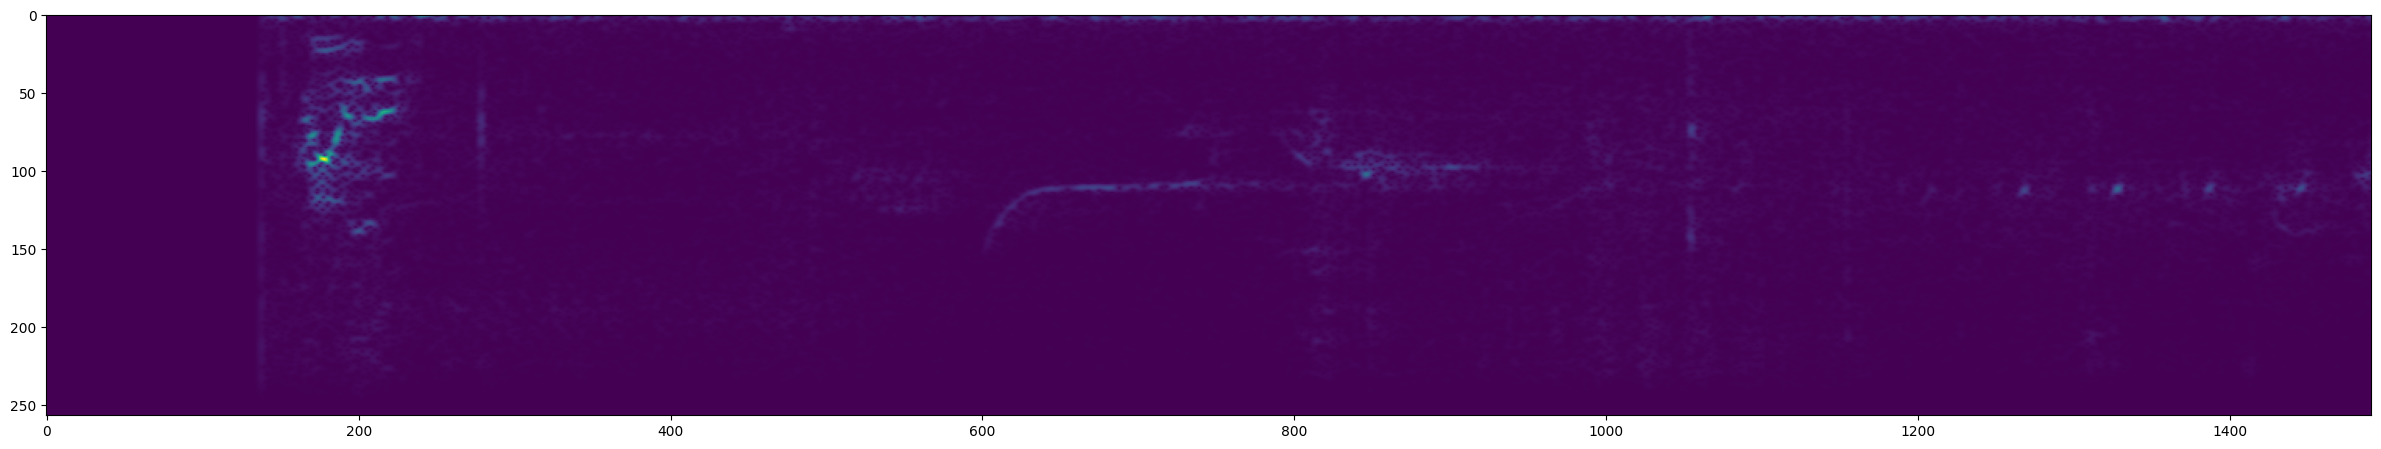

In [45]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [46]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

File Path: Tensor("args_0:0", shape=(), dtype=string)


In [47]:
len(data)

94

In [48]:
train = data.take(70)
test = data.skip(70).take(24)

In [49]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D,Reshape

In [51]:
model = Sequential()

# Add a Reshape layer to reshape the input data to have 4 dimensions
model.add(Reshape((1491, 257, 1), input_shape=(1491, 257)))

# Add Conv2D and MaxPooling2D layers
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1491, 257, 1)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1489, 255, 8)      80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 744, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 8)       584       
                                                                 
 flatten_1 (Flatten)         (None, 742000)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                11872016  
                                                      

In [54]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (E:\hackathon\tensorflow10gpu\lib\site-packages\keras\api\_v2\keras\mixed_precision\__init__.py)

In [ ]:

hist = model.fit(train, epochs=3, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

In [ ]:
yhat


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


In [ ]:
yhat

In [ ]:
tf.math.reduce_sum(yhat)

In [ ]:
tf.math.reduce_sum(y_test)

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'XC735255 - Black Stork - Ciconia nigra.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat


In [ ]:
len(yhat)

In [ ]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat
results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.6 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'black_stork_Calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])